In [49]:
import pickle

ions = ['K', 'Na', 'Ca', 'IH']
ion_dict = {}
for ion in ions:
    with open('/media/icg-channels/icg-channels-'+ion+'.pkl', 'rb') as f:
        ion_dict[ion] = pickle.load(f)
print(ion_dict['IH']['180370_ghchan.mod']['GATES']['n'])
#rint(ion_dict['Na']['138321_na.mod'])

1


In [53]:
import numpy as np
from scipy.interpolate import interp1d
from scipy import optimize

def modified_sigmoid(x,a,b,c,d):
    return c/(1+np.exp(-a*x+b)) + d

def tau_fun3(x,a,b,c,d,e,f,g,h):
    y = (x - a)
    return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))


def TAU(vm, tau):
    tt = interp1d(vm, tau, kind='cubic')
    test_vm = np.arange(-99, 99, 0.1)
    tau_test = tt(test_vm)
    return tt, np.max(tau_test), test_vm[np.argmax(tau_test)]

In [76]:
sm_str = 'SM2'
big_dict = {}
for ion in ions:
    vhalfs_a = []
    tau_vhalfs_a = []
    slope_vhalf_a = []
    tau_maxs_a = []

    vhalfs_i = []
    tau_vhalfs_i = []
    slope_vhalf_i = []
    tau_maxs_i = []
    for chan, chan_dict in ion_dict['K'].items():
        if 'ERROR_FLAGS' in chan_dict and (len(chan_dict['ERROR_FLAGS']) == 0):
            for v in chan_dict['STATES']:
                try:
                    inf = chan_dict['RATE_VALS_SS'][v]
                    tau = chan_dict['RATE_VALS_TAU'][v]
                    vms = chan_dict['RATE_VALS_V'][v]
                    tau_ip, tau_max, tau_v = TAU(vms, tau)
                    if inf[0] < inf[-1]:  # activating
                        vhalf = interp1d(inf, vms)((inf[-1]+inf[0])/2)
                        tau_maxs_a.append(tau_max)
                        vhalfs_a.append(vhalf)
                        tau_vhalfs_a.append(tau_ip(vhalf))
                        slope_vhalf_a.append((tau_ip(vhalf+0.05) - tau_ip(vhalf-0.05)) / 0.1)
                    else:
                        vhalf = interp1d(inf[::-1], vms[::-1])((inf[-1]+inf[0])/2)
                        tau_maxs_i.append(tau_max)
                        vhalfs_i.append(vhalf)
                        tau_vhalfs_i.append(tau_ip(vhalf))
                        slope_vhalf_i.append((tau_ip(vhalf+0.05) - tau_ip(vhalf-0.05)) / 0.1)
                        #print(vhalf, len(inf), len(tau), len(vms))
                except (KeyError, ValueError, IndexError) as ee:
                    pass
    big_dict[ion] = [vhalfs_a, vhalfs_i, tau_vhalfs_a, tau_vhalfs_i,
                     slope_vhalf_a, slope_vhalf_i, tau_maxs_a, tau_maxs_i]

In [70]:
print(len(slope_vhalf_a))
print(len(vhalfs_a))
print(len(tau_vhalfs_a))
print(len(slope_vhalf_i))
print(len(vhalfs_i))
print(len(tau_vhalfs_i))

765
765
765
298
298
298


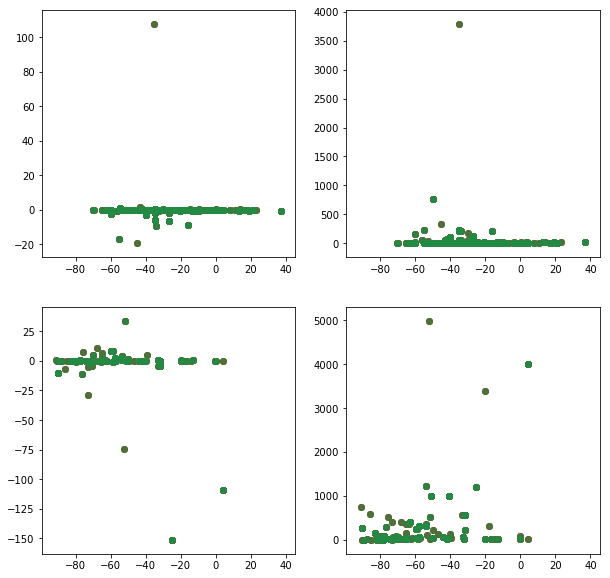

In [81]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
color_defaults = {'K' : '#6a51a3',                                                                                                                                                     
                  'Na' : '#feb24c',                                                                                                                                                    
                  'IH' : '#238b45',                                                                                                                                                    
                  'Ca' : '#b30000'} 
alpha_v = 0.7

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1], sharex=ax3)


for jj,ion in enumerate(ions):
    vhalfs_a, vhalfs_i, tau_vhalfs_a, tau_vhalfs_i, slope_vhalf_a, slope_vhalf_i, tau_maxs_a, tau_maxs_i = big_dict[ion]
    color = color_defaults[ion]
    ax1.scatter(vhalfs_a, slope_vhalf_a, c=color, alpha=0.7)
    ax2.scatter(vhalfs_i, slope_vhalf_i, c=color, alpha=0.7)
    ax3.scatter(vhalfs_a, tau_vhalfs_a, c=color, alpha=0.7)
    ax4.scatter(vhalfs_i, tau_vhalfs_i, c=color, alpha=0.7)
#        ax2.set_xlabel('V_half')
#        if ii == 0:
#            ax1.set_title('Activation')
#            ax1.set_ylabel('Slope of tau at V_half')
#            ax2.set_ylabel('Tau at V_half')
#        else:
#            ax1.set_title('Inactivation')
#ax1.set_ylim([-1*np.pi, np.pi])
plt.show()